In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [17]:
def initialize_dataframes(file_path):
    df = pd.read_csv(file_path)
    df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'Close']]
    df.index = df.pop('Date')
    return df

def init_dfs():
    df_all = initialize_dataframes('NVDA.csv')
    train_df = initialize_dataframes('NVDA_train.csv')
    test_df = initialize_dataframes('NVDA_test.csv')
    return df_all, train_df, test_df

df_all, train_df, test_df = init_dfs()


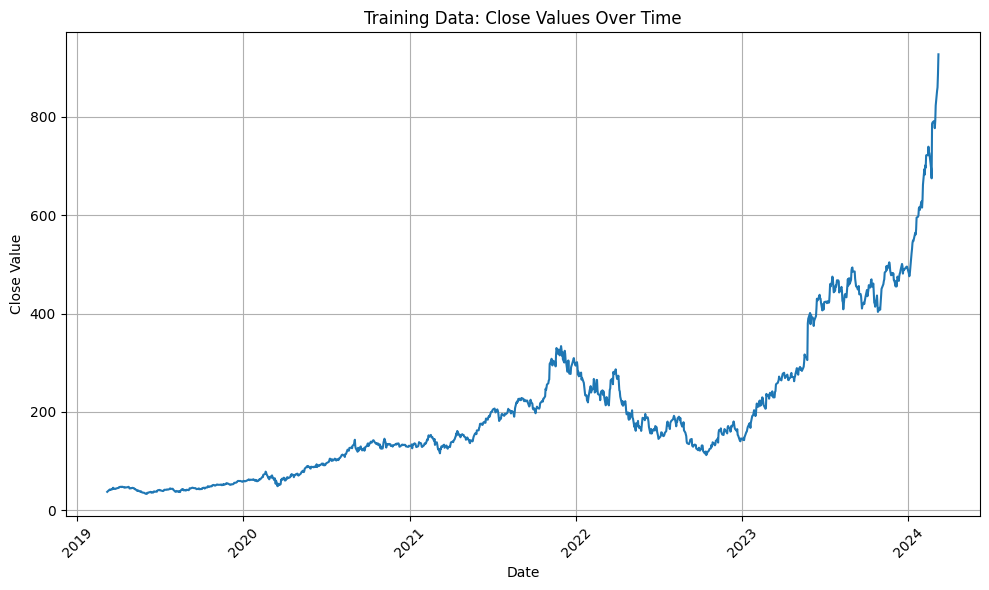

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [7]:
def generate_windowed_dataset(dataframe, start_date_str, end_date_str, col_names, target_col, window_size):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data[col_names].values
        X.append(values[:-1])

        target_value = window_data[target_col].values[-1]  # Extract the target column value
        y.append(target_value)
        dates.append(target_date)

        next_date = target_date + pd.tseries.offsets.BDay(1)  # Move to the next business day

        if next_date > end_date:
            break

        # Move to the next trading day
        while next_date not in dataframe.index:
            next_date += pd.tseries.offsets.BDay(1)

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i, col_name in enumerate(col_names):
        for j in range(window_size):
            ret_df[f'{col_name}-{window_size-j}'] = np.array(X)[:, j, i]
    ret_df[f'Target'] = y

    return ret_df


In [8]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)


# LSTM Baseline

## preprocessing

In [18]:
df_all, train_df, test_df = init_dfs()

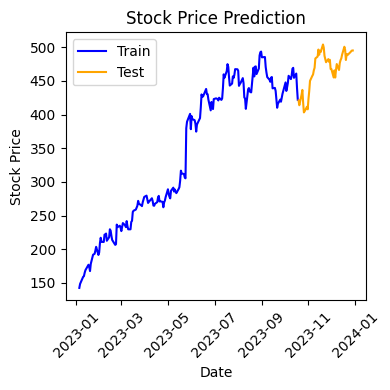

In [19]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [66]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

Epoch 1/100
7/7 [==============================] - 1s 50ms/step - loss: 127155.7344 - mean_absolute_error: 341.2245 - val_loss: 217420.8125 - val_mean_absolute_error: 465.3819
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 126809.8906 - mean_absolute_error: 340.7217 - val_loss: 216945.0781 - val_mean_absolute_error: 464.8704
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 126408.0703 - mean_absolute_error: 340.1279 - val_loss: 216267.2344 - val_mean_absolute_error: 464.1407
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 125882.0625 - mean_absolute_error: 339.3403 - val_loss: 215494.7656 - val_mean_absolute_error: 463.3076
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 125196.8984 - mean_absolute_error: 338.3190 - val_loss: 214184.8750 - val_mean_absolute_error: 461.8914
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 124122.2109 - mean_absolute_error: 336.7332 - val_los

## plotting

7/7 [==============================] - 0s 1ms/step


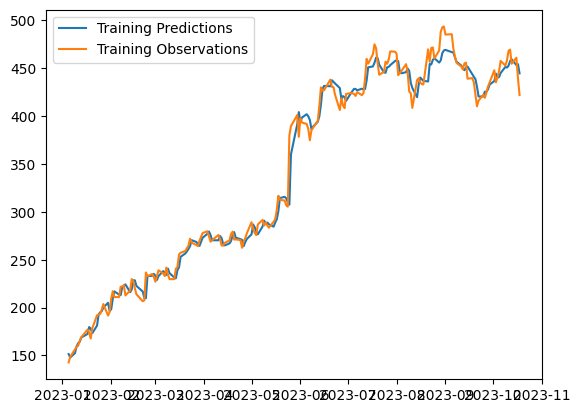

In [20]:
model = load_model('trained_models/baseline.keras')

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 2ms/step


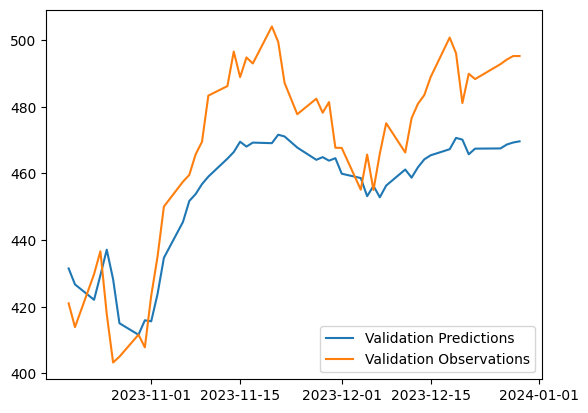

In [12]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

1/1 [==============================] - 0s 14ms/step
Test MAE: 218.48404457867701
Test MSE: 62215.82752278224
Test RMSE: 249.43100754072705


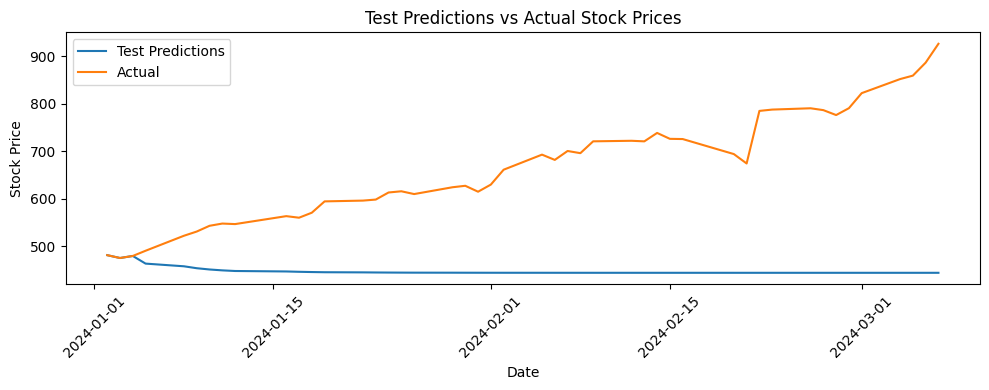

In [22]:
model = load_model('trained_models/baseline.keras')

n = 46
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()

mae_test = mean_absolute_error(actual_values, values)
mse_test = mean_squared_error(actual_values, values)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')


plt.figure(figsize=(10, 4))
# plt.plot(df_all)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Z-score scaling

## preprocessing

In [90]:
df_all, train_df, test_df = init_dfs()


train_mean = train_df['Close'].mean()
train_std = train_df['Close'].std()

test_mean = test_df['Close'].mean()
test_std = test_df['Close'].std()

# Apply z-score normalization
train_df['Close'] = (train_df['Close'] - train_mean) / train_std
test_df['Close'] = (test_df['Close'] - test_mean) / test_std

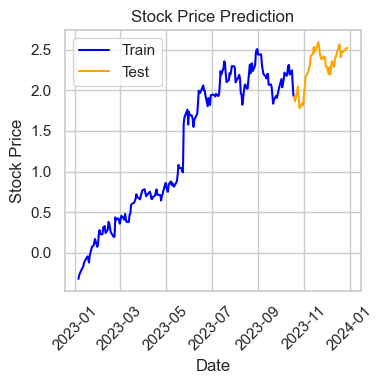

In [91]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29',  ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [39]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'zscore_.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 2.97950, saving model to trained_models\zscore_.keras

Epoch 2: val_loss improved from 2.97950 to 0.34999, saving model to trained_models\zscore_.keras

Epoch 3: val_loss improved from 0.34999 to 0.20923, saving model to trained_models\zscore_.keras

Epoch 4: val_loss improved from 0.20923 to 0.13044, saving model to trained_models\zscore_.keras

Epoch 5: val_loss did not improve from 0.13044

Epoch 6: val_loss improved from 0.13044 to 0.01839, saving model to trained_models\zscore_.keras

Epoch 7: val_loss improved from 0.01839 to 0.01201, saving model to trained_models\zscore_.keras

Epoch 8: val_loss did not improve from 0.01201

Epoch 9: val_loss did not improve from 0.01201

Epoch 10: val_loss did not improve from 0.01201

Epoch 11: val_loss did not improve from 0.01201

Epoch 12: val_loss did not improve from 0.01201

Epoch 13: val_loss improved from 0.01201 to 0.01179, saving model to trained_models\zscore_.keras

Epoch 14: val_loss did no

## plotting

2/2 [==============================] - 0s 3ms/step


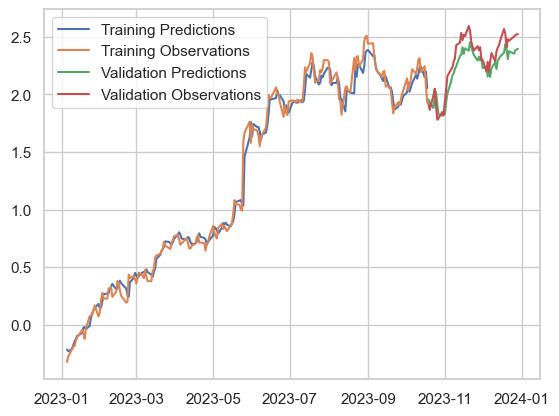

In [92]:
model = load_model('trained_models/zscore.keras')

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

1/1 [==============================] - 0s 13ms/step
Test MAE: 49.025758922137804
Test MSE: 4025.1364969186457
Test RMSE: 63.443963439547545


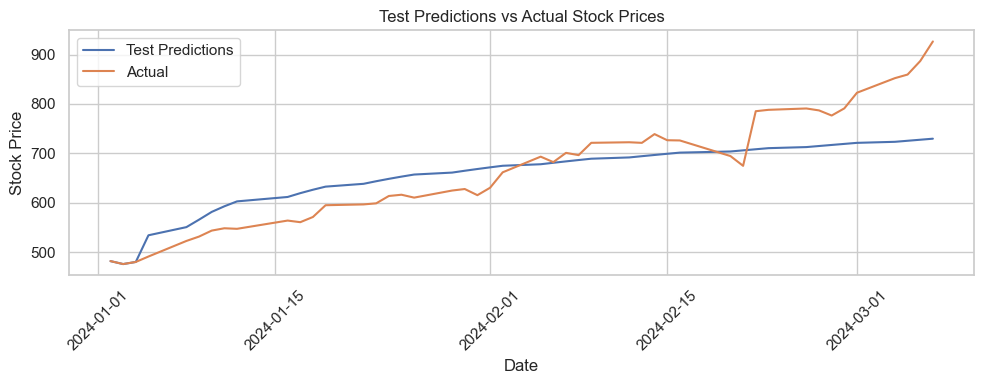

In [95]:
model = load_model('trained_models/zscore.keras')

n = 46
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)

test_predictions = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

mae_test = mean_absolute_error(actual_values, test_predictions)
mse_test = mean_squared_error(actual_values, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Returns 

## preprocessing

In [31]:
df_all, train_df, test_df = init_dfs()

df_ret_train = train_df.copy()
df_ret_train['Return'] = df_ret_train['Close'].pct_change()
df_ret_train.drop(columns=['Close'], inplace=True)
df_ret_train.dropna(inplace=True)

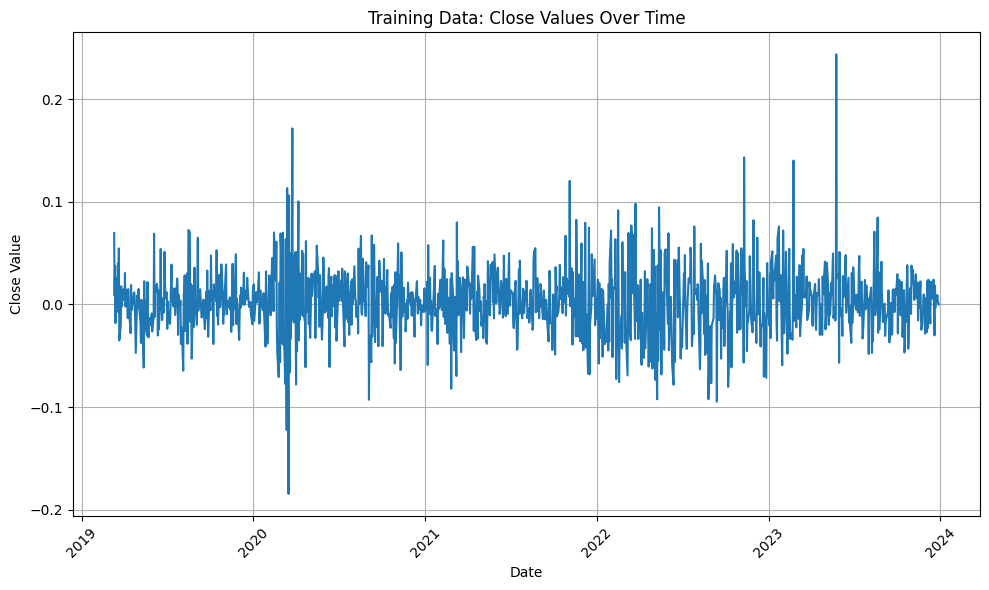

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(df_ret_train.index, df_ret_train['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


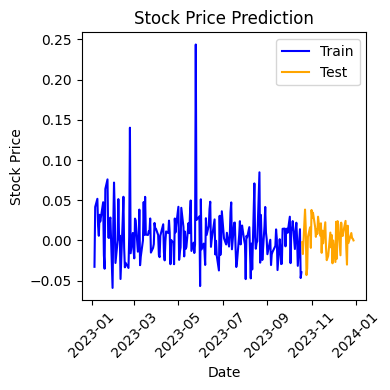

In [33]:
windowed_df = generate_windowed_dataset(df_ret_train, '2023-01-05', '2023-12-29', ['Return'], 'Return', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Training

In [30]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(120, return_sequences=False))
model.add(Dense(20))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=0)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=1)


Epoch 1/1000
7/7 [==============================] - 5s 148ms/step - loss: 0.0157 - mean_absolute_error: 0.0960 - val_loss: 5.4026e-04 - val_mean_absolute_error: 0.0198
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0455 - val_loss: 7.9690e-04 - val_mean_absolute_error: 0.0224
Epoch 3/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0245 - val_loss: 4.4100e-04 - val_mean_absolute_error: 0.0164
Epoch 4/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0232 - val_loss: 3.8049e-04 - val_mean_absolute_error: 0.0158
Epoch 5/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 3.9005e-04 - val_mean_absolute_error: 0.0164
Epoch 6/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0230 - val_loss: 5.1673e-04 - val_mean_absolute_error: 0.017

## plotting

7/7 [==============================] - 1s 2ms/step


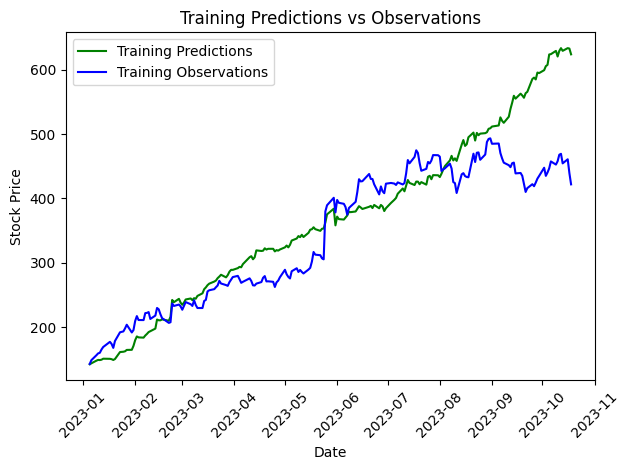

In [34]:
# Load the best model
return_model = load_model('trained_models/return.keras')

first_date = dates_train[0]
first_price = train_df.loc[first_date, 'Close']

train_predictions_pct_change = return_model.predict(X_train).flatten()
train_predictions = np.cumprod(1 + train_predictions_pct_change) * first_price


plt.plot(dates_train, train_predictions, color='green')

# Plot the real observations for the training dates
real_observations = [train_df.loc[date, 'Close'] for date in dates_train]
plt.plot(dates_train, real_observations, color='blue')

# Plot the predictions in the original price space
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Training Predictions vs Observations')
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 3ms/step


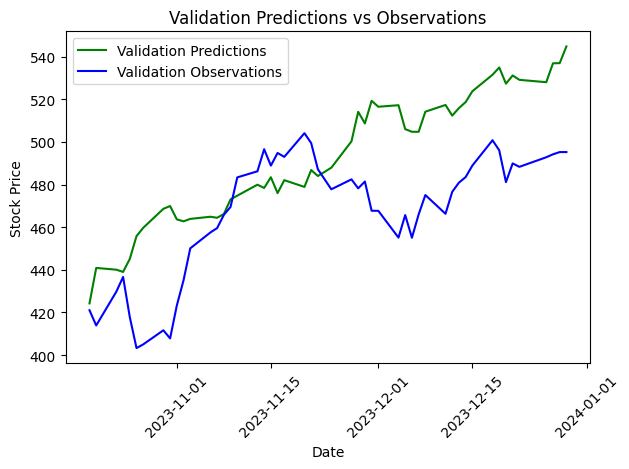

In [35]:
first_date_val = dates_val[0]
first_price_val = train_df.loc[first_date_val, 'Close']

# Obtain predictions for the validation set
val_predictions_pct_change = return_model.predict(X_val).flatten()
val_predictions = np.cumprod(1 + val_predictions_pct_change) * first_price_val


# Plot the validation predictions and observations
plt.plot(dates_val, val_predictions, color='green')

# Plot the real observations for the validation dates
real_observations_val = [train_df.loc[date, 'Close'] for date in dates_val]
plt.plot(dates_val, real_observations_val, color='blue')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Validation Predictions vs Observations')
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

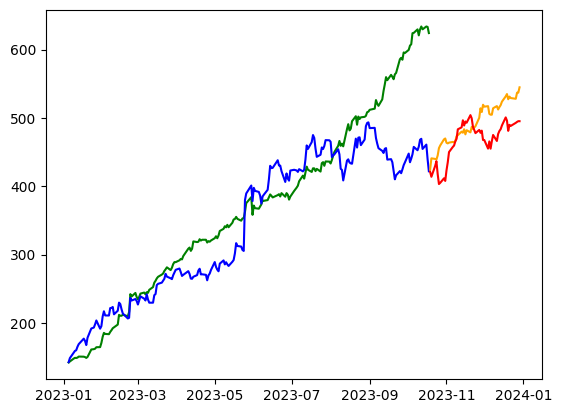

In [36]:
plt.plot(dates_train, train_predictions, color='green')
plt.plot(dates_train, real_observations, color='blue')

# Plot the validation predictions and observations
plt.plot(dates_val, val_predictions, color='orange')
plt.plot(dates_val, real_observations_val, color='red')

## evaluation on test set

1/1 [==============================] - 0s 14ms/step
Test MAE: 111.06144778345788
Test MSE: 18636.74499130487
Test RMSE: 136.51646417668775


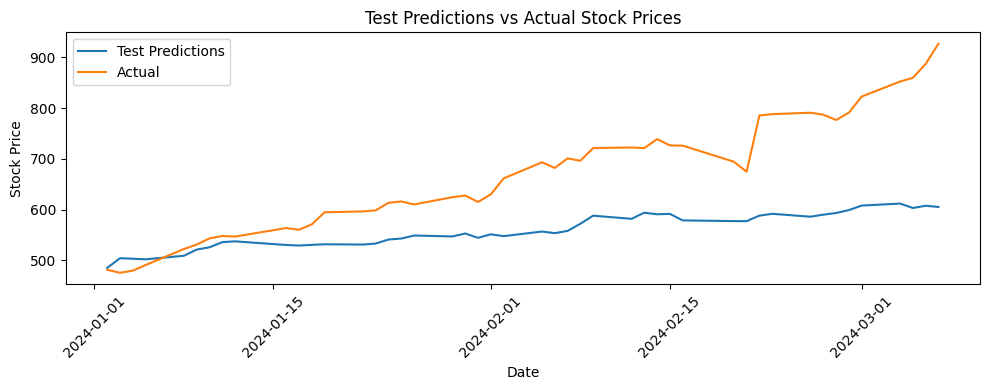

In [38]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/return.keras')

n = 46
s = 0

return_values_pct_change = test_df[['Close']].iloc[s:s+4].pct_change().dropna().to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

last_3_returns = deque(return_values_pct_change, maxlen=3)

for date in range(n-3):
    x = np.array(last_3_returns, dtype=float).reshape((1,3,1))
    test_predictions_pct_change = model.predict(x).flatten()[0]
    last_3_returns.append(test_predictions_pct_change)
    return_values_pct_change.append(test_predictions_pct_change)

first_test_value = test_df[['Close']].iloc[s, 0]
test_predictions = np.cumprod(1 + val_predictions_pct_change) * first_test_value
test_predictions = test_predictions[s:s+n]

actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()

mae_test = mean_absolute_error(actual_values, test_predictions)
mse_test = mean_squared_error(actual_values, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# News

In [7]:
import pandas as pd

file_path = 'news_retrieval/labelled_newscatcher_dataset.csv'

# Load the data and select specific columns
df = pd.read_csv(file_path, sep=';')

# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

# Select specific columns
df = df[['published_date', 'title']]

# Filter rows containing the word 'AI' in the 'title' column
df['contains_AI'] = df['title'].str.contains('AI', case=True)

# Create a new DataFrame with counts of AI articles published each day
daily_AI_counts = df.groupby(df['published_date'].dt.date)['contains_AI'].sum().reset_index()
daily_AI_counts.columns = ['published_date', 'AI_articles_count']

# Sort the new DataFrame by 'published_date'
daily_AI_counts = daily_AI_counts.sort_values(by='published_date')

print(daily_AI_counts)


    published_date  AI_articles_count
0       2012-09-16                  0
1       2015-10-23                  0
2       2016-09-23                  0
3       2016-12-08                  0
4       2016-12-22                  0
..             ...                ...
258     2020-08-14                 16
259     2020-08-15                 17
260     2020-08-16                  6
261     2020-08-17                 32
262     2020-08-18                  3

[263 rows x 2 columns]


# Multivariate LSTM

## data preprocessing

In [260]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close', 'Volume']]
train_df.index = train_df.pop('Date')

# Load index values from the CSV file
index_values = pd.read_csv('SPX.csv')[['Date', 'Close']]
index_values['Date'] = pd.to_datetime(index_values['Date'])
index_values.set_index('Date', inplace=True)

# Add a new column with the loaded index values
train_df = pd.merge(train_df, index_values, on='Date', how='left', suffixes=('', '_Index'))

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close', 'Volume']]
test_df.index = test_df.pop('Date')

def normalize_data(df):
    for col in df.columns:
        col_mean = df[col].mean()
        col_std = df[col].std()
        df[col] = (df[col] - col_mean) / col_std
    return df


train_df = normalize_data(train_df)
test_df = normalize_data(test_df)

feature_list = train_df.columns.to_list()
n_features = len(feature_list)
window_size = 3

print(feature_list)
print(train_df.tail())
print(test_df.head())


['Close', 'Volume', 'Close_Index']
               Close    Volume  Close_Index
Date                                       
2023-12-22  2.465690 -1.083663     1.570970
2023-12-26  2.501913 -1.126112     1.603922
2023-12-27  2.513046 -1.182533     1.615108
2023-12-28  2.521516 -1.113349     1.618007
2023-12-29  2.521516 -0.353530     1.595864
               Close    Volume
Date                          
2024-01-02 -1.597417 -0.758325
2024-01-03 -1.649103 -1.435018
2024-01-04 -1.612085 -1.542568
2024-01-05 -1.517254 -0.733507
2024-01-08 -1.244927  0.973556


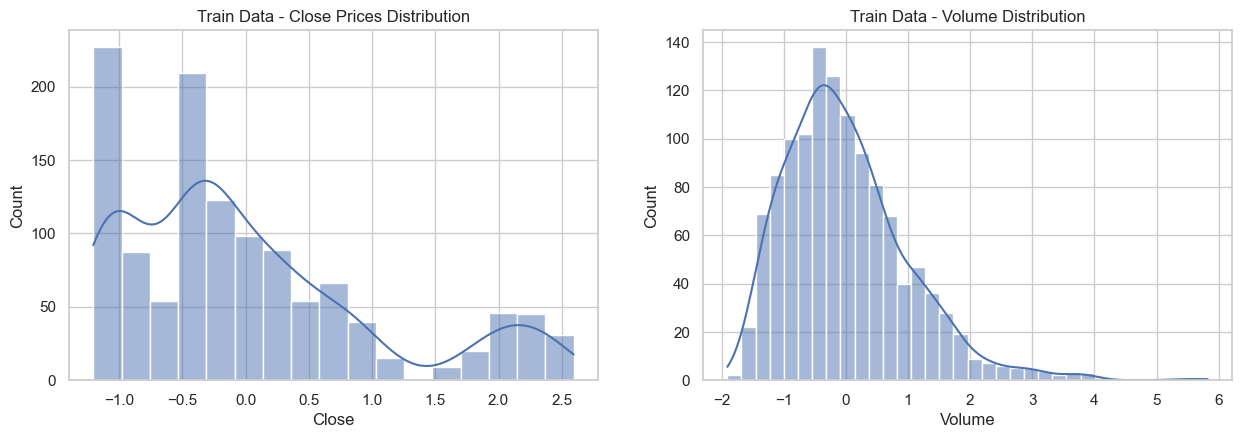

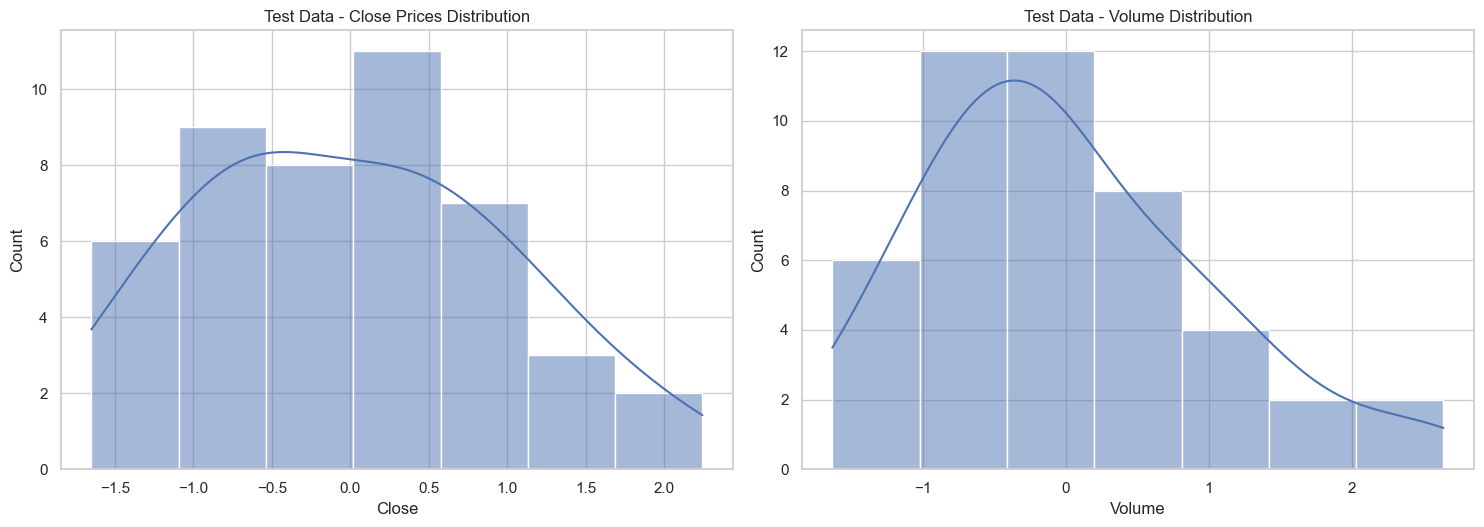

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the style of seaborn for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting for train_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 1)
sns.histplot(train_df['Close'], kde=True)
plt.title('Train Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 2)
sns.histplot(train_df['Volume'], kde=True)
plt.title('Train Data - Volume Distribution')

# Plotting for test_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 3)
sns.histplot(test_df['Close'], kde=True)
plt.title('Test Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 4)
sns.histplot(test_df['Volume'], kde=True)
plt.title('Test Data - Volume Distribution')

plt.tight_layout()
plt.show()


    Target Date   Close-3   Close-2   Close-1  Volume-3  Volume-2  Volume-1  \
0    2023-01-05 -0.294625 -0.318747 -0.283734 -0.771662 -0.286228 -0.125567   
1    2023-01-06 -0.318747 -0.283734 -0.322780 -0.286228 -0.125567 -0.350974   
2    2023-01-09 -0.283734 -0.322780 -0.274860 -0.125567 -0.350974 -0.266086   
3    2023-01-10 -0.322780 -0.274860 -0.212823 -0.350974 -0.266086  0.264263   
4    2023-01-11 -0.274860 -0.212823 -0.190154 -0.266086  0.264263 -0.378067   
..          ...       ...       ...       ...       ...       ...       ...   
243  2023-12-22  2.528131  2.407686  2.478598  0.051524 -0.304316 -0.825479   
244  2023-12-26  2.407686  2.478598  2.465690 -0.304316 -0.825479 -1.083663   
245  2023-12-27  2.478598  2.465690  2.501913 -0.825479 -1.083663 -1.126112   
246  2023-12-28  2.465690  2.501913  2.513046 -1.083663 -1.126112 -1.182533   
247  2023-12-29  2.501913  2.513046  2.521516 -1.126112 -1.182533 -1.113349   

     Close_Index-3  Close_Index-2  Close_Index-1   

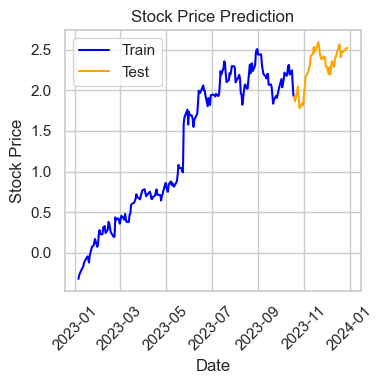

In [300]:

windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', feature_list, 'Close', window_size=3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

print(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [302]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3*n_features, len(['Close']))))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(120, return_sequences=False))
model.add(Dense(20))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'multivariate.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 0.97082, saving model to trained_models\multivariate.keras

Epoch 2: val_loss improved from 0.97082 to 0.62260, saving model to trained_models\multivariate.keras

Epoch 3: val_loss improved from 0.62260 to 0.28047, saving model to trained_models\multivariate.keras

Epoch 4: val_loss improved from 0.28047 to 0.13714, saving model to trained_models\multivariate.keras

Epoch 5: val_loss did not improve from 0.13714

Epoch 6: val_loss improved from 0.13714 to 0.05695, saving model to trained_models\multivariate.keras

Epoch 7: val_loss did not improve from 0.05695

Epoch 8: val_loss improved from 0.05695 to 0.04513, saving model to trained_models\multivariate.keras

Epoch 9: val_loss did not improve from 0.04513

Epoch 10: val_loss did not improve from 0.04513


## plotting

2/2 [==============================] - 0s 4ms/step


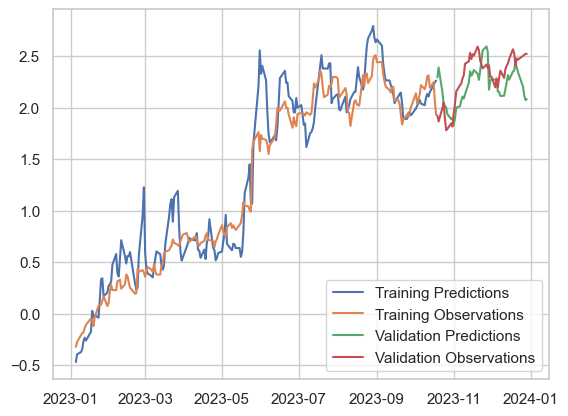

In [304]:
model = load_model('trained_models/multivariate.keras')

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

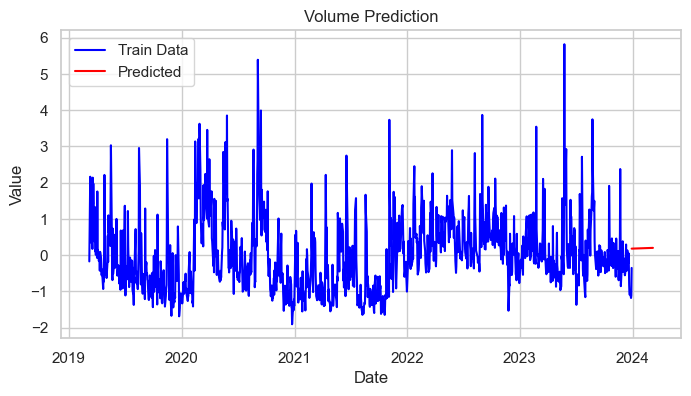

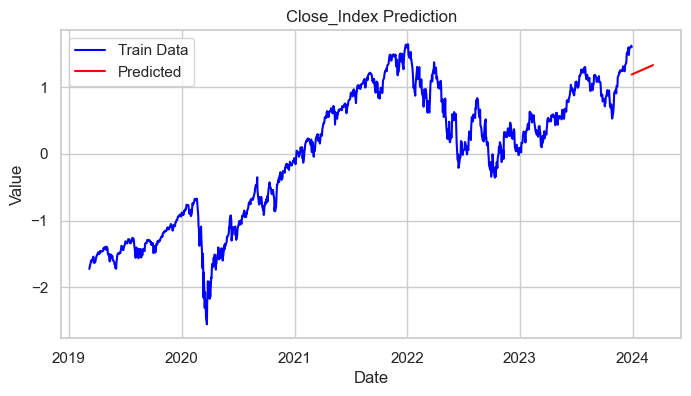

,Predicted_Volume,Predicted_Close_Index
2024-01-02,0.180655,1.193161
2024-01-03,0.181082,1.196029
2024-01-04,0.181509,1.198897
2024-01-05,0.181935,1.201766
2024-01-08,0.182362,1.204634
2024-01-09,0.182789,1.207502
2024-01-10,0.183216,1.210370
2024-01-11,0.183643,1.213239
2024-01-12,0.184070,1.216107
2024-01-15,0.184497,1.218975


In [303]:
def predict_future_values(train_df, feature_columns, future_days):
    future_df = pd.DataFrame(index=pd.bdate_range(start=train_df.index[-1], periods=future_days))

    for feature_column in feature_columns:


        split = int(len(train_df) * 0.8)
        train_data = train_df.iloc[:split]

        X_train = np.arange(len(train_data)).reshape(-1, 1)
        y_train = train_data[feature_column].values

        model = LinearRegression()
        model.fit(X_train, y_train)

        X_future = np.arange(len(train_data), len(train_data) + future_days).reshape(-1, 1)
        y_future_pred = model.predict(X_future)

        future_df[f'Predicted_{feature_column}'] = y_future_pred

        plt.figure(figsize=(8, 4))
        plt.plot(train_df.index, train_df[feature_column], label='Train Data', color='blue')
        plt.plot(future_df.index, y_future_pred, label='Predicted', color='red')
        plt.title(f'{feature_column} Prediction')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    return future_df

future_features = feature_list.copy()
future_features.remove('Close')
future_days = 50
future_df = predict_future_values(train_df, future_features, future_days)
future_df = future_df.drop(future_df.index[:2], axis=0)
future_df


deque([1.193160815059618, 1.1960290816170078, 1.1988973481743972], maxlen=3)
1/1 [==============================] - 0s 15ms/step
Test MAE: 57.30783252117072
Test MSE: 4576.339761784783
Test RMSE: 67.64864937147513


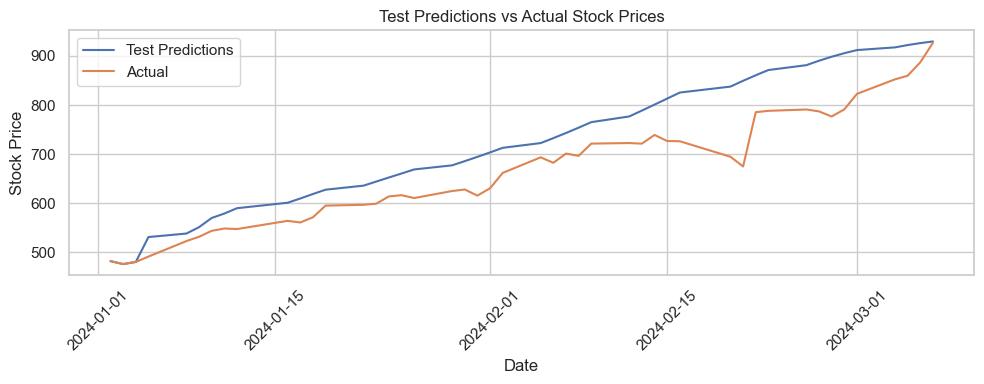

In [305]:
model = load_model('trained_models/multivariate.keras')

n = 46
s = 0

close_price_values = test_df['Close'].iloc[s:s+3].to_numpy().flatten().tolist()
volume_values = future_df['Predicted_Volume'].iloc[s:s+3].to_numpy().flatten().tolist()
index_close_price_values = future_df['Predicted_Close_Index'].iloc[s:s+3].to_numpy().flatten().tolist()

dates = test_df.iloc[s:s+n].index.to_list()

close_price_deque = deque(close_price_values, maxlen=window_size)
volume_deque = deque(volume_values, maxlen=window_size)
index_deque = deque(index_close_price_values, maxlen=window_size)

print(index_deque)

for date in range(n-3):
    x = np.concatenate((np.array(close_price_deque).reshape((-1, 3)),
                        np.array(volume_deque).reshape((-1, 3)),
                        np.array(index_deque).reshape((-1, 3))),
                        axis=1)

    pred_measure = model.predict(x).flatten()[0]
    close_price_deque.append(pred_measure)
    volume_deque.append(future_df['Predicted_Volume'].iloc[date+3])
    close_price_values.append(pred_measure)

test_predictions = [(val * test_std) + test_mean for val in close_price_values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

mae_test = mean_absolute_error(actual_values, test_predictions)
mse_test = mean_squared_error(actual_values, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')


# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Ensemble

In [146]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, average

# Load your models
baseline = load_model('trained_models/baseline.keras')
returns = load_model('trained_models/return.keras')

models = [baseline, returns]

# Define the input layers for each model
baseline_input = Input(shape=baseline.input_shape[1:])
returns_input = Input(shape=returns.input_shape[1:])

# List of input layers
model_inputs = [baseline_input, returns_input]

# Connect each input layer to its corresponding model
baseline_output = baseline(baseline_input)
returns_output = returns(returns_input)

# Collect outputs of models in a list
yModels = [baseline_output, returns_output]

# Averaging outputs
yAvg = average(yModels)

# Build model from the list of input layers and the averaged output
modelEns = Model(inputs=model_inputs, outputs=yAvg, name='ensemble')

# modelEns.summary()

# Assuming x_baseline and x_returns are the input data for baseline and returns models
pred = modelEns.predict([X_train, X_train])
print(pred)


7/7 [==============================] - 1s 2ms/step
[[3.4754126]
 [3.3046417]
 [3.5129724]
 [3.6541708]
 [3.5719292]
 [3.4695294]
 [3.5358298]
 [3.542585 ]
 [3.6354258]
 [3.412767 ]
 [3.2420564]
 [3.5749507]
 [3.788876 ]
 [3.5678196]
 [3.445062 ]
 [3.4961278]
 [3.5484545]
 [3.2196715]
 [3.3781123]
 [3.6838536]
 [3.670804 ]
 [3.3779972]
 [3.3568478]
 [3.580833 ]
 [3.4865844]
 [3.4411674]
 [3.2121594]
 [3.4066083]
 [3.6272676]
 [3.461979 ]
 [3.2686489]
 [3.21633  ]
 [3.1887732]
 [3.335368 ]
 [3.9439006]
 [3.575806 ]
 [3.465426 ]
 [3.3512373]
 [3.2853599]
 [3.4532738]
 [3.5259526]
 [3.3914092]
 [3.3330553]
 [3.516435 ]
 [3.3311682]
 [3.2753725]
 [3.3402472]
 [3.5710905]
 [3.501874 ]
 [3.6403544]
 [3.5176525]
 [3.4559171]
 [3.451855 ]
 [3.4549372]
 [3.5225677]
 [3.383739 ]
 [3.3404443]
 [3.3488662]
 [3.4644656]
 [3.4854078]
 [3.4839888]
 [3.4498398]
 [3.3370452]
 [3.2790594]
 [3.3679721]
 [3.4705074]
 [3.3699472]
 [3.2759285]
 [3.3347535]
 [3.4208288]
 [3.445887 ]
 [3.509696 ]
 [3.4761298]


# Comments

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict
# In most models its good to minmax scale, but not in the case of stock market predictions because there is no maximum value prices are always increasing
